In [1]:
import os
import importlib.util

import numpy as np
import h5py
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from evaluation.histogram_builder import *
from data.hlf_preprocessing import load

In [34]:
result_path = '/home/oliverkn/euler/results/opendata_v2/wjets_dyjets_mix/2_l16_mc_0'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor_mc = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad_mc = ALAD(config_alad, tf.Session())
ad_mc.load(os.path.join(result_path, model_file))

loading alad


In [54]:
result_path = '/home/oliverkn/euler/results/opendata_v2/6021/2_l16_data_2'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor_data = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad_data = ALAD(config_alad, tf.Session())
ad_data.load(os.path.join(result_path, model_file))


loading alad


In [55]:
#thres = 20
score_type = 'l1'
ppm = 500

cont_bins = 40
settings_6021 = {}
settings_6021['HT'] = {'range': (0, 2000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['mass_jet'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_jet'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['n_bjet'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['lep_pt'] = {'range': (20, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['lep_eta'] = {'range': (-2.5, 2.5), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
settings_6021['lep_charge'] = {'range': (-1, 1), 'yscale': 'linear', 'int': True}
settings_6021['lep_iso_ch'] = {'range': (0, 0.4), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['lep_iso_neu'] = {'range': (0, 0.4), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['lep_iso_gamma'] = {'range': (0, 0.4), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['MET'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['METo'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
settings_6021['METp'] = {'range': (-100, 100), 'yscale': 'linear', 'bins': cont_bins, 'int': False}
settings_6021['MT'] = {'range': (0, 200), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_mu'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['pt_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['mass_mu'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_ele'] = {'range': (0, 15), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['pt_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['mass_ele'] = {'range': (0, 1000), 'yscale': 'log', 'bins': cont_bins, 'int': False}
settings_6021['n_neu'] = {'range': (0, 400), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['n_ch'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
settings_6021['n_photon'] = {'range': (0, 1000), 'yscale': 'linear', 'int': True, 'bin_size': 1}
hist_settings = settings_6021

def anomaly_select(x, ad, preprocessor):
    x_transformed = preprocessor.transform(x)
    scores = ad.get_anomaly_scores(x_transformed, type=score_type)
    
    thres = np.quantile(scores, 1-ppm*1e-6)
    
    anomaly_idx = scores > thres
    return x[anomaly_idx]

def select_b0(x):
    filter_bjets =  x[:,3] == 0
    return x[filter_bjets]

def select_bn(x):
    filter_bjets =  x[:,3] > 0
    return x[filter_bjets]

def build_hists(x, ad, preprocessor, n_max, batch_size=2 ** 20):
    builder_b0 = HistogramBuilder(hist_settings)
    builder_bn = HistogramBuilder(hist_settings)
   
    n = x.shape[0]
    n = min(n, n_max)

    n_batches = int(n / batch_size) + 1
    for t in range(n_batches):
        print('batch number ' + str(t))
        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_raw = x[ran_from:ran_to]

        # anomaly select
        x_ano = anomaly_select(x_raw, ad, preprocessor)
        
        print('%d / %d = %3d_ppm' % (x_ano.shape[0], x_raw.shape[0], (x_ano.shape[0] / x_raw.shape[0]*1e6)))
        
        # select bjets=0, bjets>0
        x_ano_b0 = select_b0(x_ano)
        x_ano_bn = select_bn(x_ano)
        
        builder_b0.add_data(x_ano_b0)
        builder_bn.add_data(x_ano_bn)
        
    return builder_b0.get_histogram_data(), builder_bn.get_histogram_data()

In [58]:
n_max = 10e6

h5file = h5py.File('/home/oliverkn/pro/opendata_v2/wjets_dyjets_mix.hdf5', 'r')
x_mc = h5file['data']
hist_mc_b0, hist_mc_bn = build_hists(x_mc, ad_mc, preprocessor_mc, n_max=n_max)

h5file = h5py.File('/home/oliverkn/pro/opendata_v2/6021/data.hdf5', 'r')
x_data = h5file['data']
hist_data_b0, hist_data_bn = build_hists(x_data, ad_data, preprocessor_data, n_max=n_max)

batch number 0
525 / 1048576 = 500_ppm
batch number 1
525 / 1048576 = 500_ppm
batch number 2
525 / 1048576 = 500_ppm
batch number 3
525 / 1048576 = 500_ppm
batch number 4
525 / 1048576 = 500_ppm
batch number 5
57 / 112067 = 508_ppm
batch number 0
525 / 1048576 = 500_ppm
batch number 1
525 / 1048576 = 500_ppm
batch number 2
525 / 1048576 = 500_ppm
batch number 3
525 / 1048576 = 500_ppm
batch number 4
525 / 1048576 = 500_ppm
batch number 5
525 / 1048576 = 500_ppm
batch number 6
525 / 1048576 = 500_ppm
batch number 7
525 / 1048576 = 500_ppm
batch number 8
525 / 1048576 = 500_ppm
batch number 9
282 / 562816 = 501_ppm


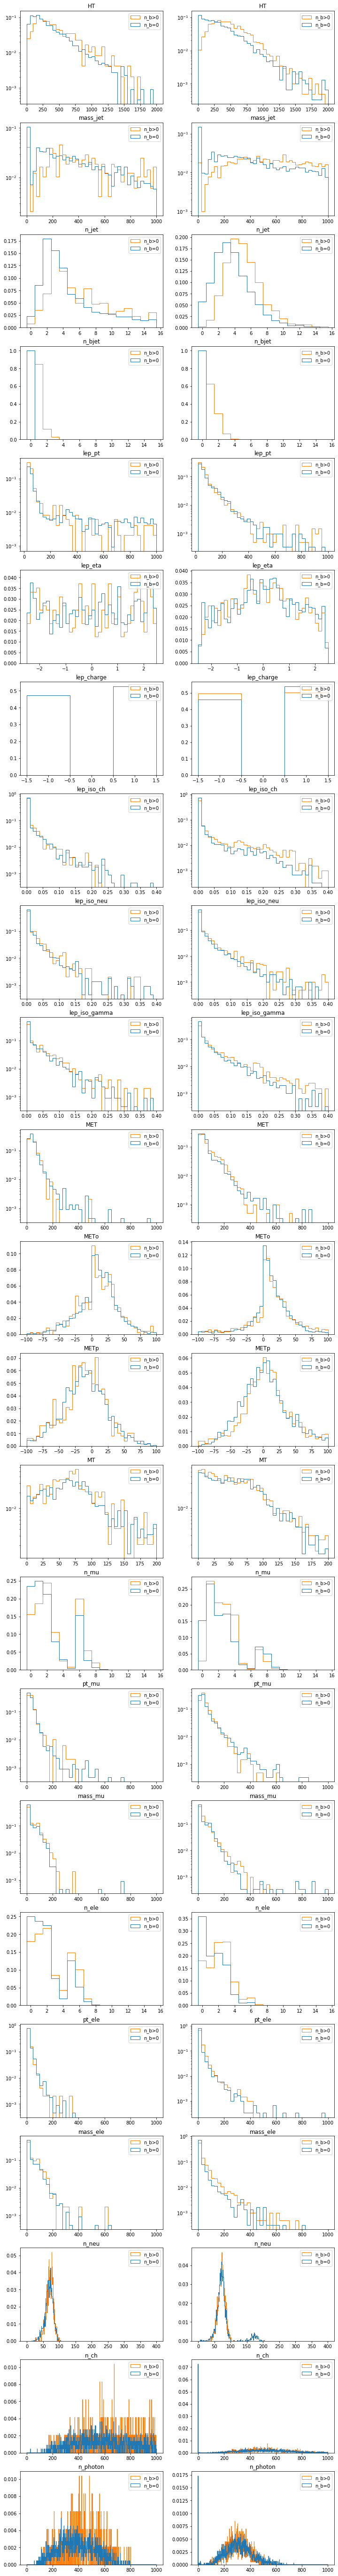

In [59]:
def plot_hist(hist_mc_dict, hist_data_dict, settings, output_file=None, all_lin=False):
    f, ax_arr = plt.subplots(23, 2, figsize=(12, 100))
    
    def plot_col(hist_dict, col):
        for row, feature in enumerate(settings.keys()):
            ax = ax_arr[row, col]
            fsettings = settings[feature]
    
            x_list = []
            bin_edges = None
            weights_list = []
            
            for key, hist in hist_dict.items():
                bin_edges = hist[feature].bin_edges
                x_list.append(hist[feature].bin_edges[:-1])
                weights_list.append(hist[feature].bin_content/hist[feature].n)
            
            ax.hist(x_list, bin_edges, weights=weights_list, stacked=False, label=hist_dict.keys(), histtype='step')
            
            if all_lin is False:
                ax.set_yscale(fsettings['yscale'])
                
            ax.set_title(feature)
            ax.legend()
        
   
    plot_col(hist_mc_dict, 0)
    plot_col(hist_data_dict, 1)
    
    if output_file is not None:
        print('saving fig to ' + output_file)
        plt.savefig(output_file)

    plt.show()
    
hist_mc_dict = {}
hist_mc_dict['n_b=0'] = hist_mc_b0
hist_mc_dict['n_b>0'] = hist_mc_bn

hist_data_dict = {}
hist_data_dict['n_b=0'] = hist_data_b0
hist_data_dict['n_b>0'] = hist_data_bn
plot_hist(hist_mc_dict, hist_data_dict, hist_settings)#, output_file='hists.pdf')